In [1]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files


In [2]:
# Mount Google Drive to save models and data
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Install kaggle API and set it up for dataset download
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # Update path if necessary
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images

# Unzip dataset
!unzip -q indian-folk-art-gallery-high-resolution-images.zip -d /content/folk-art-dataset-main/


cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images
License(s): CC-BY-NC-SA-4.0
 99% 827M/837M [00:06<00:00, 188MB/s]
100% 837M/837M [00:07<00:00, 125MB/s]


In [5]:
# Path to dataset
image_dir = '/content/folk-art-dataset-main/folk-art-dataset-main'
IMG_SIZE = 128  # Resizing images for uniformity
images = []
image_labels = []

# Load images and labels
def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                try:
                    # Load and preprocess image
                    image = Image.open(img_path).convert('RGB')
                    image = image.resize((IMG_SIZE, IMG_SIZE))
                    images.append(np.array(image))
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Get labels and load images
labels = os.listdir(image_dir)
load_images(image_dir, labels)

# Convert to numpy arrays
images = np.array(images, dtype='float32') / 255.0  # Normalize images to [0, 1]
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])

# Convert labels to one-hot encoding
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)


In [6]:
# Build the Deep CNN model
deep_cnn_model = Sequential()

# Add Convolutional Layers with MaxPooling and BatchNormalization
deep_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
deep_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
deep_cnn_model.add(BatchNormalization())

deep_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
deep_cnn_model.add(BatchNormalization())

deep_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
deep_cnn_model.add(BatchNormalization())

deep_cnn_model.add(Conv2D(256, (3, 3), activation='relu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
deep_cnn_model.add(BatchNormalization())

# Flatten the output from convolutions
deep_cnn_model.add(Flatten())

# Fully Connected Layer
deep_cnn_model.add(Dense(512, activation='relu'))
deep_cnn_model.add(Dropout(0.5))

# Output Layer
deep_cnn_model.add(Dense(len(label_to_num), activation='softmax'))

# Compile the model
deep_cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print the model summary
deep_cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [7]:
# Train the deep CNN model
history = deep_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# Save the trained model
deep_cnn_model.save('/content/drive/MyDrive/deep_cnn_folk_art_model.h5')


Epoch 1/20
808/808 [==============================] - 117s 143ms/step - loss: 4.0286 - accuracy: 0.1947 - val_loss: 2.6255 - val_accuracy: 0.3206
Epoch 2/20
808/808 [==============================] - 110s 136ms/step - loss: 2.3269 - accuracy: 0.3554 - val_loss: 2.4823 - val_accuracy: 0.3532
Epoch 3/20
808/808 [==============================] - 105s 130ms/step - loss: 1.9382 - accuracy: 0.4543 - val_loss: 1.8445 - val_accuracy: 0.4909
Epoch 4/20
808/808 [==============================] - 105s 130ms/step - loss: 1.5833 - accuracy: 0.5497 - val_loss: 1.7740 - val_accuracy: 0.5329
Epoch 5/20
808/808 [==============================] - 105s 130ms/step - loss: 1.2581 - accuracy: 0.6396 - val_loss: 1.6091 - val_accuracy: 0.5703
Epoch 6/20
808/808 [==============================] - 105s 130ms/step - loss: 1.0224 - accuracy: 0.7047 - val_loss: 1.4865 - val_accuracy: 0.6237
Epoch 7/20
808/808 [==============================] - 106s 131ms/step - loss: 0.8321 - accuracy: 0.7562 - val_loss: 1.4382 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


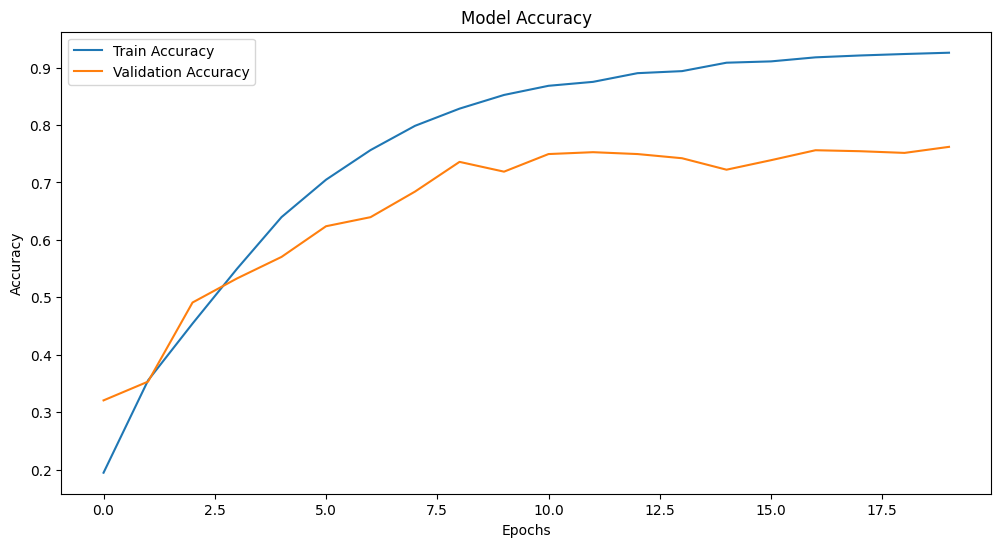

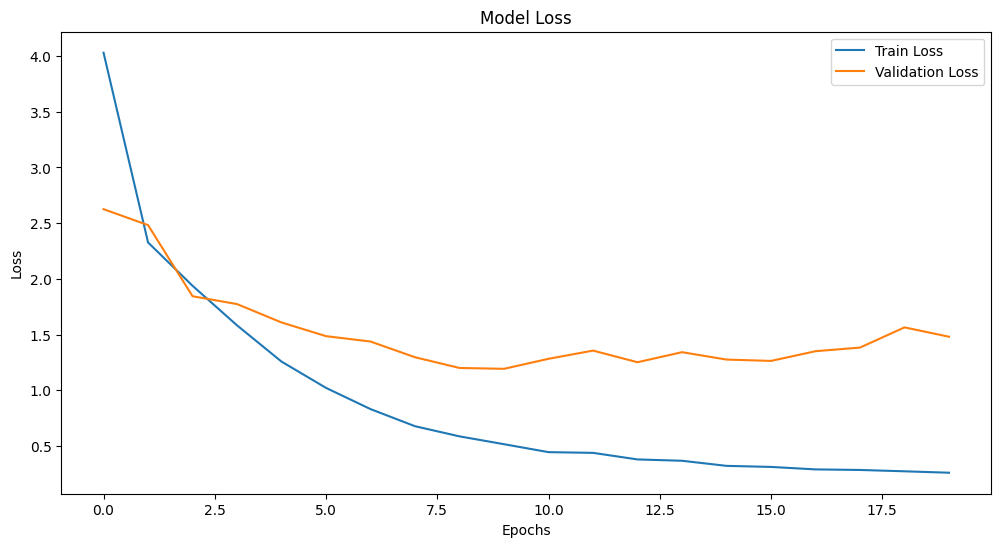

In [8]:
# Function to plot training accuracy and loss
def plot_accuracy_and_loss(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training performance
plot_accuracy_and_loss(history)


Saving 6.jpg to 6.jpg
1/1 [==============================] - 0s 140ms/step


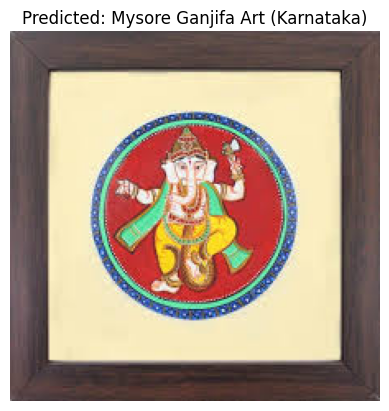

In [9]:
# Function to predict uploaded images
def predict_image(model, class_labels):
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = filename
        image = Image.open(img_path).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image = np.expand_dims(np.array(image) / 255.0, axis=0)  # Normalize and add batch dimension

        # Get predictions
        predictions = model.predict(image)
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_labels[predicted_class_idx]

        # Display prediction
        plt.imshow(Image.open(img_path))
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Test with user-uploaded images
predict_image(deep_cnn_model, list(label_to_num.keys()))
